In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import scipy.optimize
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import analysis_dir
from storage import get_storage_functions

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# input fields
#============================================================================
rfmap_analysis = 'feat_corr_map'  # 'model_perf_map' or 'feat_corr_map'
rfmap_dset     = 'corr'


#============================================================================
# preprocessing
#============================================================================
z_thres          = 1     # if not None, clip all values below this z-score
square_transform = True  # square map values (positive values) before fitting


#============================================================================
# paths
#============================================================================
rfmap_dir  = None  # defaults to analysis_dir + rfmap_analysis
output_dir = None

In [3]:
# Parameters
sess_name = "Pa210201"
rf_map_analysis = "feat_corr_map"
rfmap_dir = "../test_results/hier_group/maps_fix_hg"
output_dir = "../test_results/hier_group/maps_fix_hg"


# Check prereqs and params

In [4]:
if rfmap_dir is None:
    rfmap_dir  = analysis_dir + rfmap_analysis
if output_dir is None:
    output_dir = rfmap_dir + '-rf_fit'

rfmap_path = Path(rfmap_dir) / (sess_name + '.h5')
print('Loading RF maps from', rfmap_path)
rfmap_path = rfmap_path.expanduser()
assert rfmap_path.is_file()

output_dir = Path(output_dir)
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()
assert output_path.parent.is_dir()

Loading RF maps from ../test_results/hier_group/maps_fix_hg/Pa210201.h5
Saving results to ../test_results/hier_group/maps_fix_hg/Pa210201.h5


In [5]:
with h5.File(rfmap_path, 'r') as f:
    assert f[f'progress_report/{rfmap_analysis}/all_done'][()].item()

In [6]:
analysis_name = 'rf_fit'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'

save_results(group+'rfmap_analysis', rfmap_analysis)
save_results(group+'rfmap_dset', rfmap_dset)
save_results(group+'z_thres', np.nan if z_thres is None else z_thres)
save_results(group+'square_transform', square_transform)
with h5.File(rfmap_path, 'r') as f:
    loc = rfmap_analysis + '/unit_names'
    unit_names = f[loc][()].astype(str)
    if rfmap_path != output_path:  # else is using same file for I/O
        copy_group(f, loc, analysis_name+'/unit_names')

# Load and preprocess RF maps

In [9]:
rf_ds = xr.load_dataset(rfmap_path, group=rfmap_analysis+'/data', engine='h5netcdf')
rf_xlocs = rf_ds['rf_x'].values
rf_ylocs = rf_ds['rf_y'].values

rfs_xs = rf_ds[rfmap_dset]
rfs_pers = rf_ds[rfmap_dset+'_per_split']

# join per-split and across-split RFs along split dimension
assert 'split' in rfs_pers.coords
splits = rfs_pers.coords['split']  # for later indexting to recon per-split data
assert -1 not in splits
rfs_xs = rfs_xs.expand_dims(dim=dict(split=[-1]))
rf_ds = xr.concat([rfs_pers, rfs_xs], 'split')

# temporarily reshape values for analysis
dims_ = ('unit', 'rf_x', 'rf_y')
rfs = rf_ds
rfs = rfs.transpose(*(tuple(d for d in rfs.dims if d not in dims_)+dims_))
dims = rfs.dims
rfs = rfs.values
print(dims)

('ref_frame', 'time', 'split', 'unit', 'rf_x', 'rf_y')


In [10]:
rfs_orig = rfs.copy()  # for plotting only

# process only positive points
m = rfs > 0
npos = m.sum((-1,-2))

# optionally apply square transform
if square_transform:
    rfs[~m] = 0
    rfs[m] = np.square(rfs[m])

if z_thres is not None:
    vals = np.moveaxis(rfs, -3, 0)
    vals = vals.reshape(len(vals), -1)
    m = np.median(vals, -1)
    s = np.median(np.abs(vals - m[:,None]), -1)
    m_ = (rfs - m[:,None,None]) < z_thres * s[:,None,None]
    rfs[m_] = 0

In [11]:
nu, nx, ny = rfs.shape[-3:]
sb = rfs.shape[:-3]
rfs = rfs.reshape(-1, nu, nx, ny)
nb = rfs.shape[0]

# Main

### Maximum likelihood estimate using data moments

In [12]:
from functools import lru_cache

_nx = rf_xlocs.size
_ny = rf_ylocs.size
_ys = np.broadcast_to(rf_ylocs[:, None], (_ny, _nx)).ravel()
_xs = np.broadcast_to(rf_xlocs[None, :], (_ny, _nx)).ravel()
_xys = np.array([_xs, _ys])  # shape (2, n_yloc*n_xloc)

def gaussian_mle(weights):
    # weights shape: (n_yloc, n_xloc)
    weights = weights.ravel()

    valid_mask = np.isfinite(weights) & (weights > 0)
    valid_sel = np.nonzero(valid_mask)[0]
    weights = weights[valid_sel]
    xys_ = _xys[:,valid_sel]

    weights = weights / weights.sum()
    mu = (xys_ * weights).sum(1)  # shape (2,)
    dxys = xys_ - mu[:,None]
    sig = (dxys[...,None] * dxys.T * weights[:,None]).sum(1)
    try:
        sig_inv = np.linalg.inv(sig)
    except np.linalg.LinAlgError:
        sig_inv = np.full_like(sig, np.nan)
    return mu, sig, sig_inv

In [13]:
mus = np.full((nb, nu, 2), np.nan, dtype=np.float32)
sigs = np.full((nb, nu, 2, 2), np.nan, dtype=np.float32)
sig_invs = sigs.copy()

for ib in range(nb):
    for iu in range(nu):
        mus[ib,iu], sigs[ib,iu], sig_invs[ib,iu] = gaussian_mle(rfs[ib,iu,...].T)

### Optimize fit using least squares

In [14]:
def get_gauss2d(mux, muy, xvar_inv, yvar_inv, t):
    e1x = np.cos(t)
    e1y = np.sin(t)
    U = np.array([[e1x, -e1y], [e1y, e1x]])
    Lam_inv = np.diag([xvar_inv, yvar_inv])
    Sig_inv = U @ Lam_inv @ U.T
    mu = np.array([[mux, muy]])
    def gauss2d(xys):
        # xys: shape (n, 2)
        dxys = (xys - mu)
        return np.exp(-0.5 * dxys[:,None,:] @ Sig_inv @ dxys[:,:,None]).ravel()
    return gauss2d

def get_gauss2d_norm(xvar, yvar, t):
    e1x = np.cos(t)
    e1y = np.sin(t)
    U = np.array([[e1x, -e1y], [e1y, e1x]])
    Lam = np.diag([xvar, yvar])
    Sig = U @ Lam @ U.T
    return 1 / np.sqrt(np.linalg.det(Sig)) / 2 / np.pi

xys_ = np.array(np.meshgrid(rf_xlocs, rf_ylocs)).reshape(2,-1).T  # shape (n=nx*ny, 2)

def get_erf(nrf):
    def erf(params):
        return get_gauss2d(*params)(xys_) - nrf.ravel()
    return erf

In [15]:
def pearsonr(a, b):
    try:
        if (not a.size) or np.isclose(a.var(), 0) or np.isclose(b.var(), 0):
            return np.nan
        return np.clip(np.corrcoef(a, b)[0, 1], -1, 1)
    except:
        return np.nan

In [16]:
rf_step = np.zeros(2)
for i, (n, locs) in enumerate(zip('xy', (rf_xlocs, rf_ylocs))):
    step = np.unique(np.diff(locs))
    assert step.size == 1, f'{n}-location spacing is not uniform; got {step}'
    rf_step[i] = step
a_elem = np.prod(rf_step)

rfs = rfs.reshape(-1, nx, ny)
mus = mus.reshape(-1, 2)
sig_invs = sig_invs.reshape(-1, 2, 2)

mu2s = np.full_like(mus, np.nan)
ell1s = np.full_like(mus, np.nan, shape=(len(mus),3))
ell2s = np.full_like(ell1s, np.nan)

# stats: rf max, rf at fit peak, gof, rf x fit weighted mean, "coverage" (fit integral)
fit_stats1 = np.full((len(mus),5), np.nan)
fit_stats2 = np.full_like(fit_stats1, np.nan)

for i, (rf, mu, sig_inv) in enumerate(zip(tqdm(rfs), mus, sig_invs)):
    m = rf > 0
    if np.sum(m) <= 1:
        continue

    fit_stats1[i,0] = fit_stats2[i,0] = rf[m].max()

    nrf = rf.copy()
    nrf[~m] = 0
    nrf /= np.max(nrf)

    # convert MLE to ellipse
    if not (np.isfinite(mu).all() and np.isfinite(sig_inv).all()): continue
    (xvar_inv, yvar_inv), ((e1x, _), _) = np.linalg.eigh(sig_inv)
    if xvar_inv <= 0 or yvar_inv <= 0: continue
    xvar = 1 / xvar_inv
    yvar = 1 / yvar_inv

    ang = np.arccos(np.clip(e1x, -1, 1))
    ell1s[i,:2] = np.sqrt((xvar, yvar))
    ell1s[i,2] = ang % (2 * np.pi)

    # evaluate and init with MLE
    ix = np.digitize(mu[0], rf_xlocs) - 1
    iy = np.digitize(mu[1], rf_ylocs) - 1
    if (0 <= ix < len(rf_xlocs)) & (0 <= iy < len(rf_ylocs)):
        fit_stats1[i,1] = rf[ix, iy]
    params1 = (*mu, xvar_inv, yvar_inv, ang)
    rf_fit = get_gauss2d(*params1)(xys_).reshape(ny, nx).T  # shape (nx, ny)
    fit_stats1[i,2] = pearsonr(nrf.ravel(), rf_fit.ravel())
    if rf_fit[m].sum() == 0:
        fit_stats1[i,3] = 0
    else:
        fit_stats1[i,3] = (rf[m] * rf_fit[m]).sum() / rf_fit[m].sum()
    fit_stats1[i,4] = rf_fit.sum() * a_elem * get_gauss2d_norm(xvar, yvar, ang)

    # optimize fit
    # - nrf is ordered first by x, then by y; transpose it to match get_erf()
    params2, rtn_code = scipy.optimize.leastsq(get_erf(nrf.T), params1)

    # evaluate fit
    if rtn_code not in (1,2,3,4): continue  # failed optimization
    if not np.isfinite(params2).all() or (params2[2:4] <= 0).any(): continue
    mu2s[i] = params2[:2]
    xvar, yvar = 1 / params2[2:4]
    ell2s[i,:2] = np.sqrt((xvar, yvar))
    ell2s[i,2] = params2[4] % (2 * np.pi)
    ix = np.digitize(params2[0], rf_xlocs) - 1
    iy = np.digitize(params2[1], rf_ylocs) - 1
    if (0 <= ix < len(rf_xlocs)) & (0 <= iy < len(rf_ylocs)):
        fit_stats2[i,1] = rf[ix, iy]
    rf_fit = get_gauss2d(*params2)(xys_).reshape(ny, nx).T  # shape (nx, ny)
    fit_stats2[i,2] = pearsonr(nrf.ravel(), rf_fit.ravel())
    if rf_fit[m].sum() == 0:
        fit_stats2[i,3] = 0
    else:
        fit_stats2[i,3] = (rf[m] * rf_fit[m]).sum() / rf_fit[m].sum()
    fit_stats2[i,4] = rf_fit.sum() * a_elem * get_gauss2d_norm(xvar, yvar, ang)

100%|████████████████████████████████████████| 636/636 [00:03<00:00, 208.36it/s]

In [17]:
sig_invs = sig_invs.reshape(sb+(nu,2,2))

mu1s = mus.reshape(sb+(nu,2,))
mu2s = mu2s.reshape(sb+(nu,2,))

ell1s = ell1s.reshape(sb+(nu,3,))
ell2s = ell2s.reshape(sb+(nu,3,))

fit_stats1 = fit_stats1.reshape(sb+(nu,5,))
fit_stats2 = fit_stats2.reshape(sb+(nu,5,))

npos = npos.reshape(sb+(nu,1))

### Save results

In [18]:
compr = dict(zlib=True, complevel=9)

for est, data in (
        ('mle', (mu1s, ell1s, fit_stats1, npos)),
        ('opt', (mu2s, ell2s, fit_stats2, npos)),
):
    dims_ = dims[:-2] + ('feature',)
    coords = {d: rf_ds.coords[d].values for d in dims_[:-1]}
    coords['feature'] = np.array([
        'x','y',
        'a', 'b', 'ang_rad',
        'rf_max', 'rf_at_fit_peak', 'goodness_of_fit',
        'rf_fit_weighted_mean', 'fit_coverage', 'n'])
    data = np.concatenate(data, axis=-1, dtype=np.float32)
    da = xr.DataArray(data, dims=dims_, coords=coords, name='data')

    da_pers = da.loc[dict(split=splits)]
    da_xs = da.loc[dict(split=-1)]
    del da_xs.coords['split']
    for da_, name in ((da_pers, 'per_split'), (da_xs, 'across_splits')):
        da_.to_netcdf(
            output_path, group=f'{analysis_name}/{est}/{name}',
            mode='a', engine='h5netcdf', encoding={'data': dict(chunksizes=da_.shape, **compr)})

# Wrap up

In [19]:
save_results(f'progress_report/{analysis_name}/all_done', True, overwrite=True)

In [20]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T22:32:47.186132-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

xarray: 2023.4.2
scipy : 1.10.1
numpy : 1.24.3
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
h5py  : 3.8.0



# Basic visualization of results

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

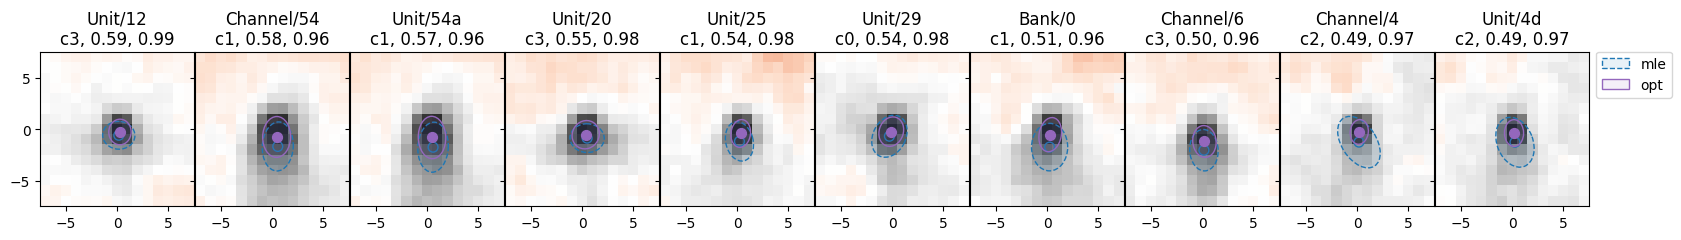

In [22]:
max_nu = 10
fit_stats = fit_stats2

fit_rfmax = fit_stats[...,0].reshape(-1, nu)  # shape: (nb, nu)
ius = np.arange(fit_rfmax.shape[-1])
ius = ius[np.isfinite(fit_rfmax).any(0)]
fit_rfmax = fit_rfmax[:,ius]  # shape: (nb, nu_)
so = np.argsort(np.nanmax(fit_rfmax, axis=0))[::-1]
ius = ius[so[:max_nu]]
fit_rfmax = fit_rfmax[...,so[:max_nu]]
nu_ = ius.size

if nu_:
    rfs_ = rfs_orig.reshape(sb+(nu,nx,ny))[...,ius,:,:].reshape(-1,nu_,nx,ny)
    mus_ = mu1s[...,ius,:].reshape(-1, nu_, 2)
    ells_ = ell1s[...,ius,:].reshape(-1, nu_, 3)
    fit_mus_ = mu2s[...,ius,:].reshape(-1, nu_, 2)
    fit_ells_ = ell2s[...,ius,:].reshape(-1, nu_, 3)
    sig_invs_ = sig_invs[...,ius,:,:].reshape(-1, nu_, 2, 2)
    fit_gof_ = fit_stats[...,2][...,ius].reshape(-1, nu_)

    fig, axs = plt.subplots(1, nu_, figsize=(2*nu_, 2), squeeze=False, sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0)
    axs = axs.ravel()
    im_ext = np.array([rf_xlocs.min(), rf_xlocs.max(), rf_ylocs.min(), rf_ylocs.max(),]) \
        + (np.array([-.5,.5]) * rf_step[:,None]).ravel()

    for i, ax in enumerate(axs):
        v = fit_rfmax[...,i]
        imax = np.nanargmax(v)
        it, = np.unravel_index(imax, v.shape)

        rf = rfs_[imax,i,:,:].T
        mu = mus_[imax,i,:]
        ell = ells_[imax,i,:]
        fit_mu = fit_mus_[imax,i,:]
        fit_ell = fit_ells_[imax,i,:]
        sig_inv = sig_invs_[imax,i,:,:]

        vm = np.nanmax(np.abs(rf))

        c = mpl.colors.to_rgb('tab:blue')

        ax.imshow(rf, extent=im_ext, origin='lower', vmin=-vm, vmax=vm, cmap='RdGy')
        ax.scatter(*mu, ec=[c], fc='none', s=50)
        if np.all(np.isfinite(mu)) and np.all(np.isfinite(ell)):
            e = mpl.patches.Ellipse(mu, *2*ell[:2], angle=ell[2]/np.pi*180, ec=c, fc=(*c,0.1), ls='--', label='mle')
            ax.add_artist(e)

        c = mpl.colors.to_rgb('tab:purple')
        ax.scatter(*fit_mu, c=[c], s=50)
        if np.all(np.isfinite(fit_mu)) and np.all(np.isfinite(fit_ell)):
            e = mpl.patches.Ellipse(fit_mu, *2*fit_ell[:2], angle=fit_ell[2]/np.pi*180, ec=c, fc=[*c,0.1], label='opt')
            ax.add_artist(e)

        ax.set_title(f'{unit_names[ius[i]]}\nc{it}, {rf.max():.2f}, {fit_gof_[it,i]:.2f}')
        ax.set_xlim(im_ext[:2])
        ax.set_ylim(im_ext[2:])

    ax.legend(bbox_to_anchor=(1,1.05), loc='upper left')